### Intro

In [1]:
%reset  -sf
# -sf  # (s for soft, f for forced without approval)
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import os.path
from numpy import log, exp

In [3]:
import sys
sys.path.append('/Volumes/Python/pyCalliphony')
from savitzki_golay import savitzky_golay

### Constants

In [4]:
# HEADERS = ('cpu_time', 'raw_pos', 'f0', 'x', 'y')  #**CHANGE FOR OLD STYLE PERF.TXT**
HEADERS = ('cpu_time', 'raw_pos', 'f0')
FRAME_DUR = 0.005
FS = 48000
# FS_ERROR_CORR = 44.1/48  # NOTE: temporary fix, put at 1 to neutralize
FS_ERROR_CORR = 1

frame_points = int(round(FRAME_DUR*FS * FS_ERROR_CORR))

##### Paths  `# << FILE NAME TO UPDATE! >>`

In [5]:
FNAME = 'limsi_fr_tat_0006_perf_22.txt'  # << FNAME TO UPDATE! >>  #**CHANGE FOR OLD STYLE PERF.TXT**
PATH = '/Users/mev/Desktop/__IS2015__/DATA/OPN_44/colere'
FPATH = os.path.join(PATH, FNAME)
if os.path.isfile(FPATH):
    print('OK:', FNAME, 'is well there.')
else:
    raise ValueError("File {} is not present in the given path!".format(FPATH))

OK: limsi_fr_tat_0006_perf_22.txt is well there.


##### Import tablet raw coordinates

In [6]:
HEADERS_RAW = ('cpu_time', 'raw_pos', 'f0', 'x', 'y')
FNAME_RAW = FNAME+'2'
FPATH_RAW = os.path.join(PATH, FNAME_RAW)
coord_raw_arr = np.genfromtxt(FPATH_RAW).reshape(-1, len(HEADERS_RAW))
coord_raw_df = pd.DataFrame(coord_raw_arr, columns=HEADERS_RAW)

In [7]:
SPEED_FACT = 3
coord_raw_df['speed'] = exp(log(SPEED_FACT) * (2*coord_raw_df.x - 1))

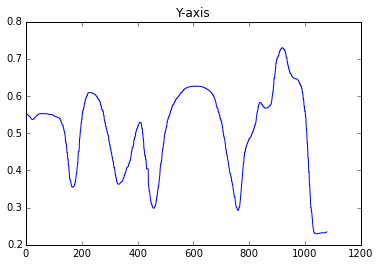

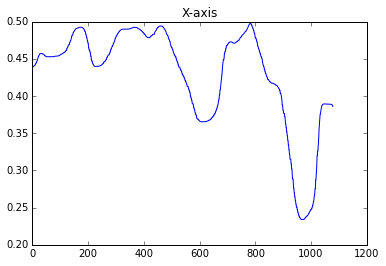

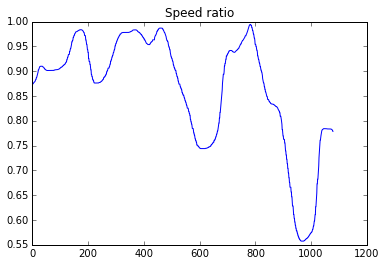

In [8]:
plt.plot(1-coord_raw_df.y)
plt.title("Y-axis")
plt.show()
plt.plot(coord_raw_df.x)
plt.title("X-axis")
plt.show()
plt.plot(coord_raw_df.speed)
plt.title("Speed ratio")
plt.show()

### Main

Reshape according to the headers num and all row (-1)

In [6]:
coord_arr = np.genfromtxt(FPATH).reshape(-1, len(HEADERS))
coord_df = pd.DataFrame(coord_arr, columns=HEADERS)
coord_df.insert(1, 'time_raw_pos', coord_df.raw_pos / FS)

coord_df.f0 *= FS_ERROR_CORR  # **CORRECT WRONG FS**

# Show the 5 first rows
coord_df[:5]

,cpu_time,time_raw_pos,raw_pos,f0
0,686155.3750,0.004979,239,289.792114
1,686155.3750,0.009958,478,289.792114
2,686159.6875,0.014937,717,288.089630
3,686164.3125,0.019896,955,286.619263
4,686169.0625,0.024854,1193,286.619263


In [7]:
# Show the 5 last rows
coord_df[-5:]

,cpu_time,time_raw_pos,raw_pos,f0
1260,690403.0625,3.579333,171808,163.454391
1261,690414.3125,3.582813,171975,163.445953
1262,690414.3750,3.586292,172142,163.445953
1263,690419.0000,3.589771,172309,163.445953
1264,690427.0000,3.593229,172475,163.750366


In [8]:
## Remove identical value at the end of coord_df.time_raw_pos
# Check if there is more than 1 row with the same value at the end
idem_interval_bool_df = np.abs(coord_df.raw_pos - coord_df.raw_pos.max()) < 5
if len(coord_df[idem_interval_bool_df]) > 1:
    coord_df = coord_df[~idem_interval_bool_df]
coord_df[-5:]

,cpu_time,time_raw_pos,raw_pos,f0
1260,690403.0625,3.579333,171808,163.454391
1261,690414.3125,3.582813,171975,163.445953
1262,690414.3750,3.586292,172142,163.445953
1263,690419.0000,3.589771,172309,163.445953
1264,690427.0000,3.593229,172475,163.750366


Include the original f0 file: to get the number of samples and to get the VUV param

In [9]:
main_path, coord_fname = os.path.split(FPATH)
f0_fpath = os.path.join(main_path, '_'.join(coord_fname.split('_')[:-2]) + '.f0')
# noinspection PyNoneFunctionAssignment
f0_orig_arr = np.fromfile(f0_fpath, dtype='f4')
f0_uv_idx = np.where(f0_orig_arr == 0)[0]  # Unvoiced indexes

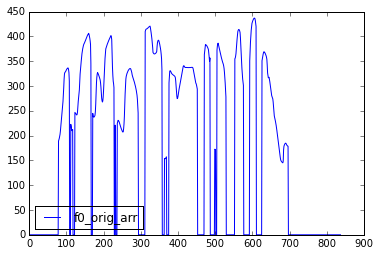

In [10]:
# print('f0_uv_idx:', f0_uv_idx)
plt.plot(f0_orig_arr)
plt.legend(['f0_orig_arr'], loc='best')
plt.show()

Extract relative time from CPU time

In [11]:
coord_time = coord_df.cpu_time - coord_df.iloc[0].cpu_time
coord_df.insert(1, 'time', coord_time / 1000)  # Ins in df after cpu_t c  #**CHANGE FOR OLD STYLE PERF.TXT**

coord_df.insert(2, 'new_pos', np.round(coord_df.time*FS))  # Insert in df after cpu_time column (ms > s)

coord_df.time *= FS_ERROR_CORR  # **Wrong FS**

In [12]:
coord_df[-5:]

,cpu_time,time,new_pos,time_raw_pos,raw_pos,f0
1260,690403.0625,4.247687,203889,3.579333,171808,163.454391
1261,690414.3125,4.258938,204429,3.582813,171975,163.445953
1262,690414.3750,4.259000,204432,3.586292,172142,163.445953
1263,690419.0000,4.263625,204654,3.589771,172309,163.445953
1264,690427.0000,4.271625,205038,3.593229,172475,163.750366


Number of elements: 1265
IN min: 0.00497916666667 IN max: 3.59322916667
OUT min: 0.0 OUT max: 4.271625


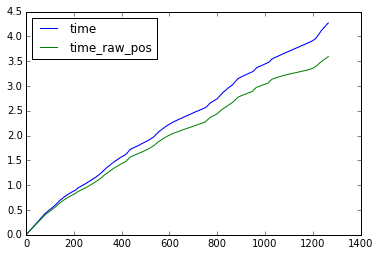

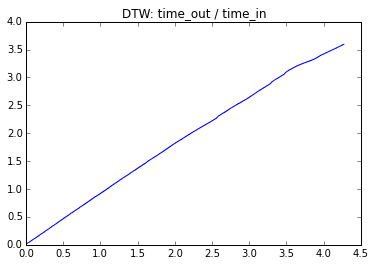

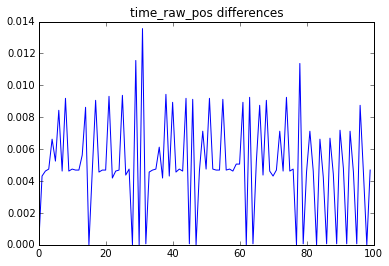

In [13]:
print("Number of elements:", len(coord_df.time))
print("IN min:", np.min(coord_df.time_raw_pos), "IN max:", np.max(coord_df.time_raw_pos))
print("OUT min:", np.min(coord_df.time), "OUT max:", np.max(coord_df.time))
plt.plot(coord_df.time)
plt.plot(coord_df.time_raw_pos)
plt.legend(['time', 'time_raw_pos'], loc='best')
plt.show()
plt.plot(coord_df.time, coord_df.time_raw_pos)
plt.title("DTW: time_out / time_in")
plt.show()

# Compute differences
time_diff_arr = np.diff(coord_df.time)
tpos_diff_arr = np.diff(coord_df.time_raw_pos)
# plt.plot(tpos_diff_arr / time_diff_arr)
# plt.plot(tpos_diff_arr)
plt.title("time_raw_pos differences")
plt.plot(time_diff_arr[:100])
plt.show()

Smooth time and f0 curves

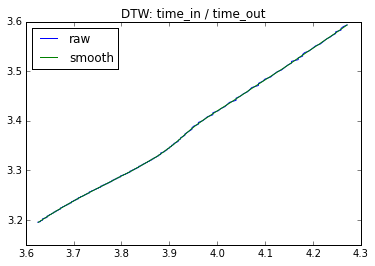

Number of elements: 1265
IN min: 0.00497916666667 IN max: 3.59322916667
OUT min: 4.33680868994e-19 OUT max: 4.271625


In [14]:
VAL = 200  # To check the last VAL elements of the array

coord_df['time_smooth'] = savitzky_golay(np.array(coord_df.time), window_size=21, order=2)
coord_df['time_smooth'] = savitzky_golay(np.array(coord_df.time), window_size=21, order=2)
coord_df['time_pos_smooth'] = savitzky_golay(np.array(coord_df.time_raw_pos), window_size=21, order=2)
coord_df['f0_smooth'] = savitzky_golay(np.array(coord_df.f0), window_size=21, order=2)

## Plot tablet info
# plt.plot(coord_df.time, coord_df.f0, coord_df.time_smooth, coord_df.f0_smooth)
# plt.legend(['f0', 'f0_smooth'], loc='best')
# plt.show()

plt.plot(coord_df.time[-VAL:], coord_df.time_raw_pos[-VAL:])
plt.plot(coord_df.time_smooth[-VAL:], coord_df.time_pos_smooth[-VAL:])
plt.title("DTW: time_in / time_out")
plt.legend(['raw', 'smooth'], loc='best')
plt.show()
print("Number of elements:", len(coord_df.time))
print("IN min:", np.min(coord_df.time_pos_smooth), "IN max:", np.max(coord_df.time_pos_smooth))
print("OUT min:", np.min(coord_df.time_smooth), "OUT max:", np.max(coord_df.time_smooth))

Number of elements: 1265
IN min: 0.00497916666667 IN max: 3.59322916667
OUT min: 0.0 OUT max: 4.271625


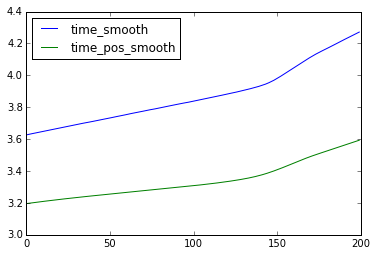

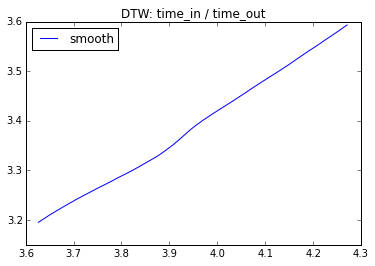

In [15]:
print("Number of elements:", len(coord_df.time_smooth))
print("IN min:", np.min(coord_df.time_pos_smooth), "IN max:", np.max(coord_df.time_pos_smooth))
print("OUT min:", np.min(coord_df.time), "OUT max:", np.max(coord_df.time_smooth))
plt.plot(coord_df.time_smooth[-VAL:])
plt.plot(coord_df.time_pos_smooth[-VAL:])
plt.legend(['time_smooth', 'time_pos_smooth'], loc='best')
plt.show()
plt.plot(coord_df.time_smooth[-VAL:], coord_df.time_pos_smooth[-VAL:])
plt.title("DTW: time_in / time_out")
plt.legend(['smooth'], loc='best')
plt.show()

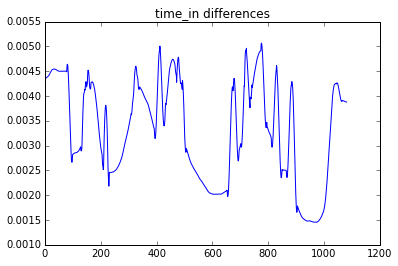

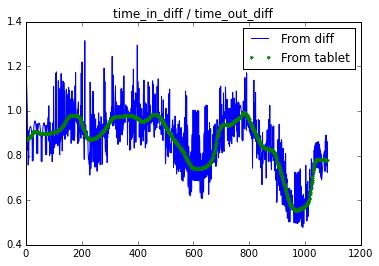

In [19]:
# Compute differences
time_smooth_diff_arr = np.diff(coord_df.time_smooth)
tpos_smooth_diff_arr = np.diff(coord_df.time_pos_smooth)

plt.plot(tpos_smooth_diff_arr)
plt.title("time_in differences")
plt.show()
plt.plot(tpos_smooth_diff_arr / time_smooth_diff_arr)
plt.plot(coord_raw_df.speed, '.')
plt.legend(['From diff', 'From tablet'], loc='best')
plt.title("time_in_diff / time_out_diff")
# plt.title("Speed ratio")
plt.show()

Warp f0 values to the original wav file time (from STRAIGHT)

In [16]:
posit_max = round(coord_df.iloc[-1].time_pos_smooth * 2, 2)/2   # get last value and round to 0.005 (0.01/2)
posit_arr = np.arange(start=FRAME_DUR, stop=posit_max, step=FRAME_DUR)   # TODO 0 > FRAME_LEN, better solution?
tck = interpolate.splrep(coord_df.time_pos_smooth, coord_df.f0_smooth, s=5)    # , s=10)
f0_warp = interpolate.splev(posit_arr, tck, der=0)

    # Set zeros to unvoiced sections
f0_uv_idx = [el for el in f0_uv_idx if el < len(f0_warp)]
f0_warp[f0_uv_idx] = 0
# interpolate.splev?

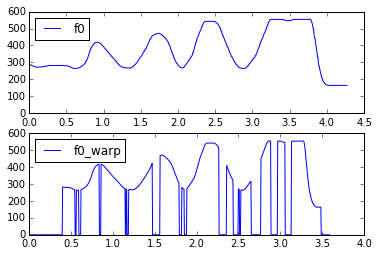

In [17]:
f1, ax_arr = plt.subplots(2, sharey=True)
ax_arr[0].plot(coord_df.time, coord_df.f0)
ax_arr[0].legend(['f0'], loc='best')
ax_arr[1].plot(posit_arr, f0_warp)
ax_arr[1].legend(['f0_warp'], loc='best')
plt.show()

##### Interpolate the time array to a STRAIGHT time mapping format (`imap = 1 : 1/(frame_points) : num_frames;`)

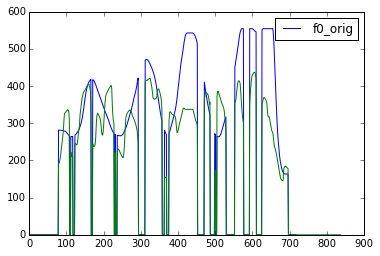

In [18]:
plt.plot(f0_warp)
plt.legend(['f0_warp'], loc='best')
plt.plot(f0_orig_arr)
plt.legend(['f0_orig'], loc='best')
plt.show()
# print(len(f0_warp), len(f0_orig_arr))

In [19]:
# num_frames = len(f0_orig_arr)
# num_frames = round(coord_df.time_raw_pos.max() / FRAME_DUR)

time_max = coord_df.time_smooth.max()
pos_max = coord_df.time_pos_smooth.max()

num_frames = round(pos_max / FRAME_DUR)

print('num_frames:', num_frames, '\t', 'time_max:', time_max, '\t', 'pos_max:', pos_max)

num_frames: 719.0 	 time_max: 4.271625 	 pos_max: 3.59322916667


Set the number of elements in the imap vector according to the total length of the target duration wav

In [20]:
# target_frame_points_avg = round(frame_points * (time_max/pos_max))
target_frame_points_avg = frame_points * (time_max/pos_max)

print('global time ratio:', time_max/pos_max)
print('target_frame_points_avg:', target_frame_points_avg)

global time ratio: 1.18879837658
target_frame_points_avg: 285.311610378


In [21]:
imap_idx = np.arange(start=1, stop=num_frames, step=1 / (target_frame_points_avg)) #*FS_ERROR_CORR))  # **WRONG FS**
# imap_time = imap_idx / num_frames * pos_max / 1.000001    # FIXME: eps val > avoid rounding problem in interpol

print('imap_idx:', imap_idx)
print("Length imap_idx:", len(imap_idx))

imap_idx: [   1.            1.00350494    1.00700988 ...,  718.9904096   718.99391454
  718.99741948]
Length imap_idx: 204854


Apply the interpollation to the imap vector

* TRY: using simple interpollations `cpu_t` to `pos_t`

imap_time: [ 0.00594106  0.00596189  0.00598271 ...,  4.27156802  4.27158885
  4.27160967]
time_map: [ 0.01212212  0.01214732  0.01217252 ...,  3.59319149  3.59320526
  3.59321903]
imap: [   2.4256196     2.43066167    2.43570374 ...,  718.99246141  718.99521649
  718.99797157]


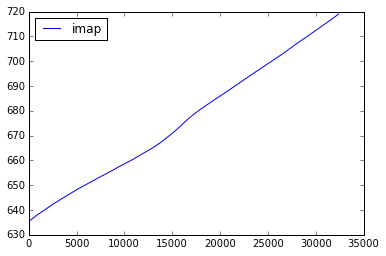

In [22]:
imap_time = imap_idx / num_frames * time_max
print('imap_time:', imap_time)

# time_interp_fct = interpolate.interp1d(coord_df['time_smooth'], coord_df['time_pos_smooth'], 'linear')
# time_map = time_interp_fct(imap_time)

# time_idx2 = np.linspace(0, coord_df.time_smooth.max(), len(coord_df.time_smooth))
# time_map = np.interp(x=imap_time, xp=time_idx2, fp=coord_df.time_pos_smooth)

time_map = np.interp(x=imap_time, xp=coord_df.time_smooth, fp=coord_df.time_pos_smooth)
print('time_map:', time_map)

imap = time_map * num_frames / pos_max * FS_ERROR_CORR**2  # **WRONG FS**  # normalize max val to tot numb of frames
print('imap:', imap)

val = VAL*len(imap)/len(coord_df)
plt.plot(imap[-val:])
plt.legend(['imap'], loc='best')
plt.show()

In [24]:
# np.arange(10)
# np.linspace(0, 10)
# time_idx2

##### Simulate an typically example of an expected imap result   `# DEBUG TEST!!**`

In [25]:
# COEF = 3
# imap_1 = np.arange(1, np.round(num_frames/COEF)-1/(frame_points*2), step=1/(frame_points*2))
# imap_2 = np.arange(np.round(num_frames/COEF), num_frames, step=1/(frame_points/2))
# imap_exp = np.concatenate([imap_1, imap_2])

# plt.plot(imap_exp)
# plt.legend(['imap_exp'], loc='best')
# plt.show()

### Write to file

In [26]:
fbase_path = os.path.splitext(FPATH)[0]
with open(fbase_path+'.newf0', 'w') as f_newf0:
    f0_warp.astype('float32').tofile(f_newf0)     # f0_warp DEBUG
#     coord_df['f0_smooth'].values.astype('float32').tofile(f_newf0)
with open(fbase_path+'.newpos', 'w') as f_newpos:
    imap.astype('float32').tofile(f_newpos)

print('Done!')

Done!
